앙상블 학습
- Ensemble Learning 을 통한 분류는 여러 개의 Classifier를 생성하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법
- 어려운 문제의 결론을 내기 위해 여러 명의 전문가로 위원회를 구성해 다양한 의견을 수렴하고 결정하듯이 앙상블 학습의 목표는 다양한 분류기의 예측 결과를 결합함으로써 단일 분류기보다 신뢰성이 높은 예측값을 얻는 것
- 유형
  - Voting, Bagging, Boosting, Stacking
- 대표적 배깅 : Random Forest
- 부스팅 : 에이다 부스팅, 그래디언트 부스팅, XGBoost, LightGBM
- 정형 데이터 분류나 회귀 : GBM 부스팅 계열의 앙상블
- 앙상블 특징
  - 단일 모델의 약점을 다수의 모델들을 결합하여 보완
  - 성능이 떨어지더라도 서로 다른 유형의 모델을 섞는 것이 오히려 전체 성능에 도움이 됨
  - 랜덤 포레스트 및 부스팅 알고리즘들은 모두 결정 트리 알고리즘을 기반 알고리즘으로 적용함
  - 단점인 과적합을 수십~수천개의 많은 분류기를 결합해 보완하고 장점인 직관적인 분류 기준은 강화됨

- 보팅과 배깅은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
- 보팅은 서로 다른 알고리즘을 가진 분류기를 결합, 배깅은 각각의 분류기가 모두 같은 유형의 알고리즘 기반, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행하는 것임

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 위스콘신 유방암 데이터 로드
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
# VotingClassifier로 개별모델은 로지스틱 회귀와 KNN을 보팅방식으로 결합하고 성능 비교
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Bagging - Random Forest
- 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정
부트스트래핑 분할
- 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트. 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑(bootstrapping) 분할 방식이라고 함
(배깅(Bagging)이 bootstrap aggregating의 줄임말)
- 원본 데이터 건수가 10개인 학습 데이터 세트에 랜덤 포레스트를 3개의 결정 트리 기반으로 학습 하려고 n_estimators=3으로 하이퍼 파라미터를 부여하면 3개의 데이터 서브세트가 만들어짐
- RandomForestClassifier 하이퍼 파라미터
  - n_estimators : 결정 트리의 개수. default=10
  - max_features : 결정 트리의 max_features 와 동일. default=auto. 'sqrt'와 같음. 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수) 만큼 참조
  - max_depth, min_samples_leaf : 결정 트리에서 과적합 개선하기 위해 사용되는 파라미터도 동일 적용

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '14LoA41ooTFHpQ4ApQgX9DDoCAMYjQwuV' # url에서 file id만 copy/paste
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('features.txt')

file_id = '15l8T6S_zl2eGQ4wpk3O_IAraQNbEweqq'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('X_train.txt')

file_id = '1_oSZJCT-JeXDuI50Qgaw8WeI64ARetRt'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('X_test.txt')

file_id = '1Brie2VEVhzvzk3LS7piksHzAqh_iaXX_'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('y_train.txt')

file_id = '1vjxC8PCXNCp-i7dd6iCenpGPlULPBYLq'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('y_test.txt')

In [0]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(
      lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [0]:
def get_human_dataset():

  # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당.
  feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
  # 중복된 feature 명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame 생성.
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습 피처 데이터 셋과 테스트 피처 데이터를 DataFrame으로 로딩. 컬럼명은 feature_name 적용
  X_train = pd.read_csv('X_train.txt',sep='\s+', names=feature_name)
  X_test = pd.read_csv('X_test.txt',sep='\s+', names=feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 컬럼명은 action으로 부여
  y_train = pd.read_csv('y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('y_test.txt', sep='\s+', header=None, names=['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

학습/테스트 데이터로 분리하고 랜덤 포레스트로 학습/예측/평가

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy))

랜덤 포레스트 정확도:0.9253


GridSearchCV 로 교차검증 및 하이퍼 파라미터 튜닝

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [8]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,\
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


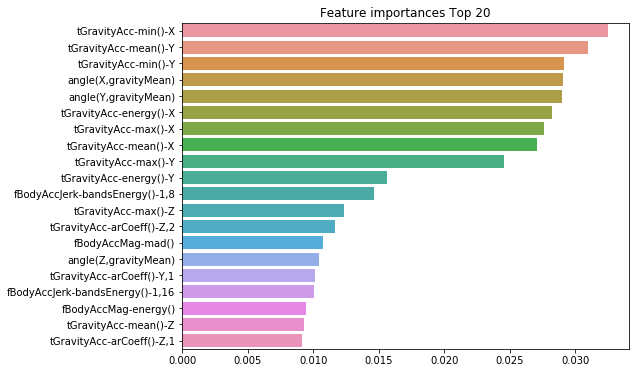

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

부스팅(Boosting)
- 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 대표적 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있음

GBM (Gradient Boost Machine)
- 가중치 업데이트를 경사 하강법(Gradient Descent)을 이용하는 것
- 오류 값은 (실제 값 - 예측 값). 분류의 실제 결과값을 y, 피처를 X1, X2, ... , Xn 그리고 이 피처에 기반한 예측함수를 F(x)함수라고 하면 오류식 h(x) = y - F(x)가 됨.
- 이 오류식 h(x) = y - F(x)를 최소화 하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것이 경사 하강법. 경사 하강법은 반복 수행을 통해 오류를 최소화할 수 있도록 가중치의 업데이트 값을 도출하는 기법

GBM의 GradientBoostingClassifier 주요 하이퍼 파라미터 및 튜닝
- loss : 경사 하강법에서 사용할 비용 함수 지정. 기본값은 'deviance'
- learning_rate : 학습을 진행 할 때마다 적용하는 학습률. Weak learner가 순차적으로 오류 값을 보정해 나가는데 적용하는 계수. 0~1 사이의 값 지정할 수 있으며 기본값은 0.1임. 
  - 너무 작은 값을 적용하면 업데이트 되는 값이 작아져서 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 높음
  - 많은 weak learner는 순차적인 반복이 필요해서 수행 시간이 오래 걸리고, 또 너무 작게 설정하면 모든 weak learner의 반복이 완료되도 최소 오류 값을 찾기 못할 수 있음
  - 반대로 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능이 떨어질 가능성이 높아지지만, 빠른 수행이 가능
- n_estimators : weak learner의 개수. 순차적으로 오류를 보정하므로 개수가 많을수록 예측 성능이 일정 수준까지는 좋아짐. 개수가 많을수록 수행 시간이 오래 걸림. 기본값 100
- subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율. 기본값은 1이며, 이는 전체 학습 데이터를 기반으로 학습한다는 의미(0.5면 학습데이터의 50%). 과적합이 염려되는 경우는 subsample을 1보다 작은 값으로 설정함

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위한 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time)함

GBM 정확도: 0.9386
GBM 수행 시간: 834.3 초


In [0]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 83.6min finished


최적 하이퍼 파라미터:
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도:0.9013


In [10]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score
0,"{'max_depth': 6, 'min_samples_leaf': 8, 'min_s...",0.912405,28,0.902339,0.922470
1,"{'max_depth': 6, 'min_samples_leaf': 8, 'min_s...",0.912405,28,0.902339,0.922470
2,"{'max_depth': 6, 'min_samples_leaf': 8, 'min_s...",0.910501,33,0.901251,0.919750
3,"{'max_depth': 6, 'min_samples_leaf': 12, 'min_...",0.910365,34,0.897171,0.923558
4,"{'max_depth': 6, 'min_samples_leaf': 12, 'min_...",0.910365,34,0.897171,0.923558
5,"{'max_depth': 6, 'min_samples_leaf': 12, 'min_...",0.910365,34,0.897171,0.923558
6,"{'max_depth': 6, 'min_samples_leaf': 18, 'min_...",0.911317,30,0.902339,0.920294
7,"{'max_depth': 6, 'min_samples_leaf': 18, 'min_...",0.911317,30,0.902339,0.920294
8,"{'max_depth': 6, 'min_samples_leaf': 18, 'min_...",0.911317,30,0.902339,0.920294
9,"{'max_depth': 8, 'min_samples_leaf': 8, 'min_s...",0.914309,20,0.905060,0.923558


In [11]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9196
